<a href="https://colab.research.google.com/github/damladmrk/GeneticAlgorithms/blob/main/GASudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Genetic Algorithm Explanation

In this notebook, we implement a simple **Genetic Algorithm (GA)** to solve an optimization problem.  
The algorithm works as follows:

1. **Initialization**  
   - A random population of candidate solutions is generated.  
   - Each solution is represented as a set of values (genes).  

2. **Fitness Evaluation**  
   - Every solution is evaluated using a **fitness function**, which measures how good the solution is for the problem.  

3. **Selection**  
   - The best-performing individuals are selected as parents.  
   - We use strategies such as **roulette-wheel selection** or **tournament selection** to ensure that better solutions have a higher chance of being chosen.  

4. **Crossover (Recombination)**  
   - Two parent solutions are combined to create new offspring.  
   - This allows the algorithm to explore new areas of the solution space.  

5. **Mutation**  
   - Some genes in the offspring are randomly modified.  
   - Mutation helps maintain genetic diversity and prevents the population from converging too early.  

6. **New Generation**  
   - The offspring replace the old population (fully or partially).  
   - The process repeats until a **stopping condition** is met (e.g., maximum generations achieved).  


---
This notebook demonstrates how populations evolve over generations, gradually improving towards an optimal or near-optimal solution.


In [19]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
# 0 represents empty cells
sudoku_board = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

solved_sudoku = [
    [5, 3, 4, 6, 7, 8, 9, 1, 2],
    [6, 7, 2, 1, 9, 5, 3, 4, 8],
    [1, 9, 8, 3, 4, 2, 5, 6, 7],
    [8, 5, 9, 7, 6, 1, 4, 2, 3],
    [4, 2, 6, 8, 5, 3, 7, 9, 1],
    [7, 1, 3, 9, 2, 4, 8, 5, 6],
    [9, 6, 1, 5, 3, 7, 2, 8, 4],
    [2, 8, 7, 4, 1, 9, 6, 3, 5],
    [3, 4, 5, 2, 8, 6, 1, 7, 9]
]

In [4]:
# -------------------------
# 1) Print function
# -------------------------
def print_sudoku(board):
    """
    Nicely print a 9x9 sudoku board. Empty cells are represented by 0.
    """
    sep_line = "+-------+-------+-------+"
    for r in range(9):
        if r % 3 == 0:
            print(sep_line)
        row_str = ""
        for c in range(9):
            if c % 3 == 0:
                row_str += "| "
            val = board[r][c]
            row_str += (str(val) if val != 0 else ".") + " "
        row_str += "|"
        print(row_str)
    print(sep_line)

In [5]:
print_sudoku(sudoku_board)

+-------+-------+-------+
| 5 3 . | . 7 . | . . . |
| 6 . . | 1 9 5 | . . . |
| . 9 8 | . . . | . 6 . |
+-------+-------+-------+
| 8 . . | . 6 . | . . 3 |
| 4 . . | 8 . 3 | . . 1 |
| 7 . . | . 2 . | . . 6 |
+-------+-------+-------+
| . 6 . | . . . | 2 8 . |
| . . . | 4 1 9 | . . 5 |
| . . . | . 8 . | . 7 9 |
+-------+-------+-------+


In [6]:
print_sudoku(solved_sudoku)

+-------+-------+-------+
| 5 3 4 | 6 7 8 | 9 1 2 |
| 6 7 2 | 1 9 5 | 3 4 8 |
| 1 9 8 | 3 4 2 | 5 6 7 |
+-------+-------+-------+
| 8 5 9 | 7 6 1 | 4 2 3 |
| 4 2 6 | 8 5 3 | 7 9 1 |
| 7 1 3 | 9 2 4 | 8 5 6 |
+-------+-------+-------+
| 9 6 1 | 5 3 7 | 2 8 4 |
| 2 8 7 | 4 1 9 | 6 3 5 |
| 3 4 5 | 2 8 6 | 1 7 9 |
+-------+-------+-------+


In [7]:
def sudoku_errors(board):
    errors = 0

    for i in range(9):
        row_seen = {}
        col_seen = {}
        for j in range(9):
            val_row = board[i][j]
            if val_row != 0:
                if val_row in row_seen:
                    errors += 1
                else:
                    row_seen[val_row] = True

            val_col = board[j][i]
            if val_col != 0:
                if val_col in col_seen:
                    errors += 1
                else:
                    col_seen[val_col] = True

    for box_row in range(0, 9, 3):
        for box_col in range(0, 9, 3):
            box_seen = {}
            for i in range(3):
                for j in range(3):
                    val = board[box_row+i][box_col+j]
                    if val != 0:
                        if val in box_seen:
                            errors += 1
                        else:
                            box_seen[val] = True

    return errors


In [25]:
def fitness(individual, board):
    test_board = create_board(board, individual)
    errors = sudoku_errors(test_board)
    return 81 - errors

In [12]:
def create_individual(board):
    chromosome = []
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                chromosome.append(random.randint(1, 9))
    return chromosome

In [13]:
def create_population(board, population_size=100):
    population = []
    for _ in range(population_size):
        individual = create_individual(board)
        population.append(individual)
    return population

In [14]:
def create_board(board, soln):
  new_board = [row[:] for row in board]
  s = 0
  for i in range(9):
      for j in range(9):
          if new_board[i][j] == 0:
            new_board[i][j] = soln[s]
            s += 1
  return new_board

In [15]:
def crossover(parent1, parent2):
    point = random.randint(1, len(parent1)-1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

In [16]:
def mutate(individual, mutation_rate=0.05):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.randint(1, 9)
    return individual

## Parent Selection Strategy: Top Half Selection

### Why I Used the Selection Strategy
  

To ensure that the genetic algorithm **focuses more on the fittest solutions**, we changed the strategy to **Top Half Selection**. This means we first sort the population based on fitness and then select parents only from the top 50%. By doing this:
- We guarantee that only stronger individuals are chosen as parents.
- The algorithm converges faster because weak individuals are excluded from reproduction.
- It reduces randomness while maintaining enough genetic diversity.

### How It Works
1. **Sort the population** based on fitness (highest fitness first).
2. **Take the elit part** most fitted ones directly added to the new population.  
3. **Take the top half** of the population as potential parents.  
4. **Randomly select parents** from this top half to generate offspring.  

This approach strikes a balance between **exploitation** (using the best solutions) and **exploration** (random selection within the top half).




In [17]:
def select_mating_pool(population, board, elite_ratio=0.1):
    sorted_pop = sorted(population, key=lambda ind: fitness(ind, board), reverse=True)

    elite_count = max(1, int(len(population) * elite_ratio))
    elites = sorted_pop[:elite_count]

    half = len(population) // 2
    pool = sorted_pop[:half]

    return elites, pool


In [18]:
def create_new_population(population, board, elite_ratio=0.1):
    elites, pool = select_mating_pool(population, board, elite_ratio)
    new_population = elites[:]
    while len(new_population) < len(population):
        parent1 = random.choice(pool)
        parent2 = random.choice(pool)
        child = crossover(parent1, parent2)
        child = mutate(child)
        new_population.append(child)

    return new_population


In [36]:
# hyperparams
POP_SIZE      = 100
GENERATIONS   = 500
MUTATION_RATE = 0.05
ELITE_RATIO   = 0.10
REPORT_EVERY  = 10

In [37]:
population = create_population(sudoku_board, population_size=POP_SIZE)
best_hist, avg_hist = [], []

In [38]:
for gen in range(1, GENERATIONS + 1):
    # evaluate
    fits = [fitness(ind, sudoku_board) for ind in population]
    best_idx = max(range(len(population)), key=lambda i: fits[i])
    best_fit = fits[best_idx]
    avg_fit  = sum(fits) / len(fits)
    best_hist.append(best_fit)
    avg_hist.append(avg_fit)

    # progress print
    if gen % REPORT_EVERY == 0 or best_fit >= 81:
        # accuracy = fitness / 81
        acc = max(0.0, min(1.0, best_fit / 81.0))
        print(f"Gen {gen:4d} | Best fitness: {best_fit:5.1f} | Avg: {avg_fit:5.1f} | Accuracy: {acc*100:5.1f}%")

    # solved?
    if best_fit >= 81:
        print(f"\n✅ Solved at generation {gen}!")
        solved = create_board(sudoku_board, population[best_idx])
        try:
            print_sudoku(solved)
        except:
            for row in solved: print(row)
        break

    # next generation (elitism + top-half mating pool)
    elites, pool = select_mating_pool(population, sudoku_board, elite_ratio=ELITE_RATIO)
    new_pop = elites[:]
    while len(new_pop) < len(population):
        p1 = random.choice(pool)
        p2 = random.choice(pool)
        c1, c2 = crossover(p1, p2)
        c1 = mutate(c1, mutation_rate=MUTATION_RATE)
        c2 = mutate(c2, mutation_rate=MUTATION_RATE)
        new_pop.extend([c1, c2])
    population = new_pop[:len(population)]
else:
    # even if the best couldn't find show the best
    print("\n⚠️ No perfect solution found.")
    best_idx = max(range(len(population)), key=lambda i: fitness(population[i], sudoku_board))
    best_fit = fitness(population[best_idx], sudoku_board)
    print(f"Best fitness after {GENERATIONS} generations: {best_fit}")
    best_board = create_board(sudoku_board, population[best_idx])
    try:
        print_sudoku(best_board)
    except:
        for row in best_board: print(row)

Gen   10 | Best fitness:  31.0 | Avg:  23.3 | Accuracy:  38.3%
Gen   20 | Best fitness:  40.0 | Avg:  32.3 | Accuracy:  49.4%
Gen   30 | Best fitness:  45.0 | Avg:  37.2 | Accuracy:  55.6%
Gen   40 | Best fitness:  50.0 | Avg:  42.7 | Accuracy:  61.7%
Gen   50 | Best fitness:  53.0 | Avg:  44.5 | Accuracy:  65.4%
Gen   60 | Best fitness:  55.0 | Avg:  47.2 | Accuracy:  67.9%
Gen   70 | Best fitness:  55.0 | Avg:  48.2 | Accuracy:  67.9%
Gen   80 | Best fitness:  56.0 | Avg:  48.5 | Accuracy:  69.1%
Gen   90 | Best fitness:  57.0 | Avg:  48.7 | Accuracy:  70.4%
Gen  100 | Best fitness:  58.0 | Avg:  49.7 | Accuracy:  71.6%
Gen  110 | Best fitness:  58.0 | Avg:  50.4 | Accuracy:  71.6%
Gen  120 | Best fitness:  59.0 | Avg:  49.3 | Accuracy:  72.8%
Gen  130 | Best fitness:  59.0 | Avg:  52.5 | Accuracy:  72.8%
Gen  140 | Best fitness:  60.0 | Avg:  51.4 | Accuracy:  74.1%
Gen  150 | Best fitness:  60.0 | Avg:  52.4 | Accuracy:  74.1%
Gen  160 | Best fitness:  60.0 | Avg:  52.4 | Accuracy:

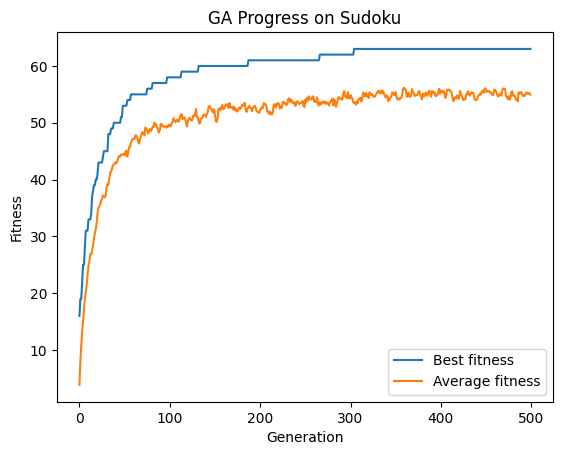

In [39]:
# plot progress
plt.figure()
plt.plot(best_hist, label="Best fitness")
plt.plot(avg_hist,  label="Average fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("GA Progress on Sudoku")
plt.legend()
plt.show()

# Row-wise Individual Initialization for Genetic Sudoku Solver

In a standard Genetic Algorithm (GA) for solving Sudoku, individuals (chromosomes) represent candidate solutions.

If we initialize each individual completely randomly, many obvious rule violations occur from the start. This results in a large number of errors and makes the GA take much longer to converge.

To improve efficiency, we use **row-wise initialization**:

1. For each row, we identify which numbers (1-9) are missing.  
2. We randomly shuffle these missing numbers.  
3. We fill the empty cells in that row with the shuffled numbers.  

Advantages:

- Each row is valid from the start (no duplicate numbers in a row).  
- The population starts with fewer errors, allowing the GA to focus on fixing column and 3x3 box conflicts.  
- This approach significantly improves convergence speed and overall GA performance.

This strategy provides a smarter initial population while maintaining randomness, which is essential for the GA to explore different solutions.


In [42]:
def create_individual_v2(board):
    """
    Creates an individual chromosome for GA Sudoku solver.
    Fills each row's empty cells with missing numbers in random order.
    """
    chromosome = []
    for i in range(9):
        row = board[i]
        missing_numbers = [n for n in range(1,10) if n not in row]
        empty_indices = [j for j in range(9) if row[j] == 0]
        random.shuffle(missing_numbers)
        for idx, j in enumerate(empty_indices):
            chromosome.append(missing_numbers[idx])
    return chromosome

In [43]:
def create_population_v2(board, population_size=100):
    population = []
    for _ in range(population_size):
        individual = create_individual_v2(board)
        population.append(individual)
    return population

In [44]:
population_v2 = create_population_v2(sudoku_board, population_size=POP_SIZE)
best_hist_v2, avg_hist_v2 = [], []

In [45]:
for gen in range(1, GENERATIONS + 1):
    # evaluate
    fits = [fitness(ind, sudoku_board) for ind in population_v2]
    best_idx = max(range(len(population)), key=lambda i: fits[i])
    best_fit = fits[best_idx]
    avg_fit  = sum(fits) / len(fits)
    best_hist_v2.append(best_fit)
    avg_hist_v2.append(avg_fit)

    # progress print
    if gen % REPORT_EVERY == 0 or best_fit >= 81:
        # accuracy = fitness / 81
        acc = max(0.0, min(1.0, best_fit / 81.0))
        print(f"Gen {gen:4d} | Best fitness: {best_fit:5.1f} | Avg: {avg_fit:5.1f} | Accuracy: {acc*100:5.1f}%")

    # solved?
    if best_fit >= 81:
        print(f"\n✅ Solved at generation {gen}!")
        solved = create_board(sudoku_board, population_v2[best_idx])
        try:
            print_sudoku(solved)
        except:
            for row in solved: print(row)
        break

    # next generation (elitism + top-half mating pool)
    elites, pool = select_mating_pool(population_v2, sudoku_board, elite_ratio=ELITE_RATIO)
    new_pop = elites[:]
    while len(new_pop) < len(population_v2):
        p1 = random.choice(pool)
        p2 = random.choice(pool)
        c1, c2 = crossover(p1, p2)
        c1 = mutate(c1, mutation_rate=MUTATION_RATE)
        c2 = mutate(c2, mutation_rate=MUTATION_RATE)
        new_pop.extend([c1, c2])
    population_v2 = new_pop[:len(population_v2)]
else:
    # even if the best couldn't find show the best
    print("\n⚠️ No perfect solution found.")
    best_idx = max(range(len(population)), key=lambda i: fitness(population_v2[i], sudoku_board))
    best_fit = fitness(population_v2[best_idx], sudoku_board)
    print(f"Best fitness after {GENERATIONS} generations: {best_fit}")
    best_board = create_board(sudoku_board, population_v2[best_idx])
    try:
        print_sudoku(best_board)
    except:
        for row in best_board: print(row)

Gen   10 | Best fitness:  50.0 | Avg:  39.2 | Accuracy:  61.7%
Gen   20 | Best fitness:  53.0 | Avg:  44.8 | Accuracy:  65.4%
Gen   30 | Best fitness:  53.0 | Avg:  47.0 | Accuracy:  65.4%
Gen   40 | Best fitness:  56.0 | Avg:  47.1 | Accuracy:  69.1%
Gen   50 | Best fitness:  59.0 | Avg:  51.6 | Accuracy:  72.8%
Gen   60 | Best fitness:  61.0 | Avg:  52.5 | Accuracy:  75.3%
Gen   70 | Best fitness:  61.0 | Avg:  54.5 | Accuracy:  75.3%
Gen   80 | Best fitness:  61.0 | Avg:  53.9 | Accuracy:  75.3%
Gen   90 | Best fitness:  61.0 | Avg:  53.8 | Accuracy:  75.3%
Gen  100 | Best fitness:  61.0 | Avg:  54.4 | Accuracy:  75.3%
Gen  110 | Best fitness:  61.0 | Avg:  54.0 | Accuracy:  75.3%
Gen  120 | Best fitness:  61.0 | Avg:  54.1 | Accuracy:  75.3%
Gen  130 | Best fitness:  61.0 | Avg:  54.2 | Accuracy:  75.3%
Gen  140 | Best fitness:  61.0 | Avg:  54.9 | Accuracy:  75.3%
Gen  150 | Best fitness:  61.0 | Avg:  55.0 | Accuracy:  75.3%
Gen  160 | Best fitness:  62.0 | Avg:  54.5 | Accuracy:

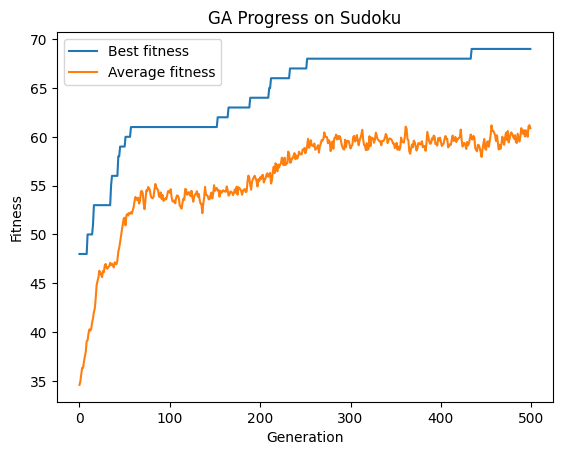

In [47]:
# plot progress
plt.figure()
plt.plot(best_hist_v2, label="Best fitness")
plt.plot(avg_hist_v2,  label="Average fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("GA Progress on Sudoku")
plt.legend()
plt.show()